# Calculating the Radial Distribution Function (RDF) from Simulation Data

This tutorial will show how to calculate the radial distribution function (RDF) $g(r)$ between specific atom types, excluding intramolecular correlations. The file type used in the example is a [GSD](https://gsd.readthedocs.io/) file, but the methods for filtering the neighbor list can be applied to other simulation data types.

In [1]:
import freud
import gsd.hoomd
import matplotlib.pyplot as plt
import numpy as np

For convenience, we'll define two functions: `snap_molecule_indices` which will help us determine which particle indices are in which molecule and `intermolecular_rdf` which will compute the RDF from our gsd file.

In [2]:
def snap_molecule_indices(snap):
    """Find molecule index for each particle.

    Given a snapshot from a trajectory, compute clusters of bonded molecules
    and return an array of the molecule index of each particle.

    Parameters
    ----------
    snap : gsd.hoomd.Snapshot
        Trajectory snapshot.

    Returns
    -------
    numpy array (N_particles,)

    """
    system = freud.AABBQuery.from_system(snap)
    num_query_points = num_points = snap.particles.N
    query_point_indices = snap.bonds.group[:, 0]
    point_indices = snap.bonds.group[:, 1]
    vectors = system.box.wrap(
        system.points[query_point_indices] - system.points[point_indices]
    )
    nlist = freud.NeighborList.from_arrays(
        num_query_points, num_points, query_point_indices, point_indices, vectors
    )
    cluster = freud.cluster.Cluster()
    cluster.compute(system=system, neighbors=nlist)
    return cluster.cluster_idx


def intermolecular_rdf(
    gsdfile,
    A_name,
    B_name,
    start=0,
    stop=None,
    r_max=None,
    r_min=0,
    bins=100,
    exclude_bonded=True,
):
    """Compute intermolecular RDF from a GSD file.

    This function calculates the radial distribution function given a GSD file
    and the names of the particle types. By default it will calculate the RDF
    for the entire trajectory.

    It is assumed that the bonding, number of particles, and simulation box do
    not change during the simulation.

    Parameters
    ----------
    gsdfile : str
        Filename of the GSD trajectory.
    A_name, B_name : str
        Name(s) of particles between which to calculate the RDF (found in
        gsd.hoomd.Snapshot.particles.types)
    start : int
        Starting frame index for accumulating the RDF. Negative numbers index
        from the end. (Default value = 0)
    stop : int
        Final frame index for accumulating the RDF. If None, the last frame
        will be used. (Default value = None)
    r_max : float
        Maximum radius of RDF. If None, half of the maximum box size is used.
        (Default value = None)
    r_min : float
        Minimum radius of RDF. (Default value = 0)
    bins : int
        Number of bins to use when calculating the RDF. (Default value = 100)
    exclude_bonded : bool
        Whether to remove particles in same molecule from the neighbor list.
        (Default value = True)

    Returns
    -------
    freud.density.RDF
    """
    with gsd.hoomd.open(gsdfile) as trajectory:
        snap = trajectory[0]

        if r_max is None:
            # Use a value just less than half the maximum box length.
            r_max = np.nextafter(
                np.max(snap.configuration.box[:3]) * 0.5, 0, dtype=np.float32
            )

        rdf = freud.density.RDF(bins=bins, r_max=r_max, r_min=r_min)

        type_A = snap.particles.typeid == snap.particles.types.index(A_name)
        type_B = snap.particles.typeid == snap.particles.types.index(B_name)

        if exclude_bonded:
            molecules = snap_molecule_indices(snap)
            molecules_A = molecules[type_A]
            molecules_B = molecules[type_B]

        for snap in trajectory[start:stop]:
            A_pos = snap.particles.position[type_A]
            if A_name == B_name:
                B_pos = A_pos
                exclude_ii = True
            else:
                B_pos = snap.particles.position[type_B]
                exclude_ii = False

            box = snap.configuration.box
            system = (box, A_pos)
            aq = freud.locality.AABBQuery.from_system(system)
            nlist = aq.query(
                B_pos, {"r_max": r_max, "exclude_ii": exclude_ii}
            ).toNeighborList()

            if exclude_bonded:
                pre_filter = len(nlist)
                indices_A = molecules_A[nlist.point_indices]
                indices_B = molecules_B[nlist.query_point_indices]
                nlist.filter(indices_A != indices_B)
                post_filter = len(nlist)

            rdf.compute(aq, neighbors=nlist, reset=False)
        normalization = post_filter / pre_filter if exclude_bonded else 1
        return rdf, normalization

In the following example, we'll look at a simulation of PTB7 polymer. Here is the chemical structure of the PTB7 monomer:

![data/ptb7.png](data/ptb7.png)

We're going to look at the correlation between the sulfur atoms (atom type "ss"), but notice that ptb7 has multiple sulfur atoms in it which are held in place by bonds. We wouldn't expect the distances between these intramolecular sulfur atoms to change much based on the thermodynamic state of the simulation.

Let's see what our sulfur-sulfur RDF looks like if we _do not_ exclude intramolecular interactions.

In [3]:
gsdfile = "data/ptb7-5mers.gsd"
A_name = "ss"
B_name = "ss"

In [4]:
%%time
rdf, normalization = intermolecular_rdf(
    gsdfile, A_name, B_name, r_max=6, exclude_bonded=False
)

CPU times: user 9.84 s, sys: 429 ms, total: 10.3 s
Wall time: 1.21 s


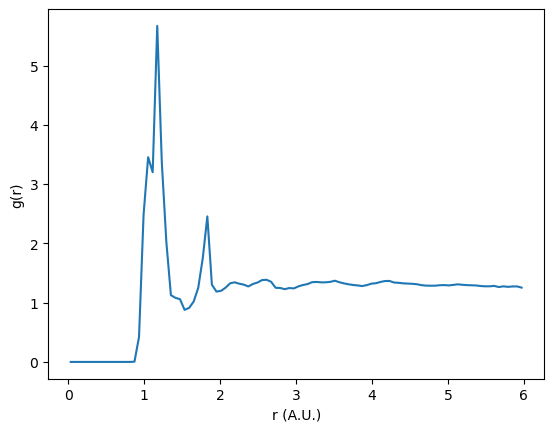

In [5]:
plt.plot(rdf.bin_centers, rdf.rdf * normalization)
plt.xlabel("r (A.U.)")
plt.ylabel("g(r)")
plt.show()

We can see that the RDF is dominated by a couple of sharp distinct peaks. By excluding intramolecular correlations from the RDF, we may be able to probe deeper into the phase behavior of the system.

In [6]:
%%time
rdf, normalization = intermolecular_rdf(
    gsdfile, A_name, B_name, r_max=6, exclude_bonded=True
)
print(f"Normalization for bonded pair exclusion: {normalization:.5f}")

Normalization for bonded pair exclusion: 0.91959
CPU times: user 13.9 s, sys: 485 ms, total: 14.3 s
Wall time: 4.78 s


Additionally when excluding bonded interactions, a correction to the normalization is needed. This value is returned in the output. This normalization factor accounts for the change in the number of pairs before and after filtering the neighbor list.

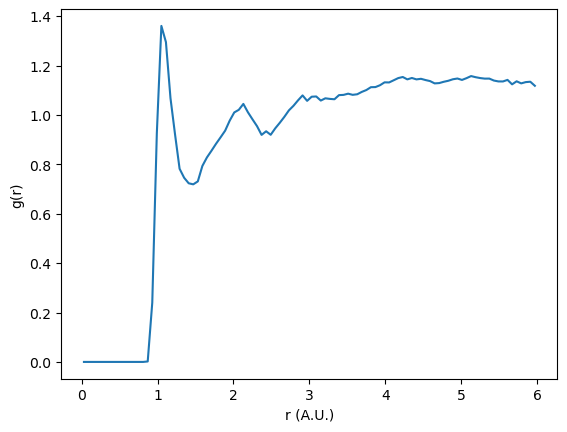

In [7]:
plt.plot(rdf.bin_centers, rdf.rdf * normalization)
plt.xlabel("r (A.U.)")
plt.ylabel("g(r)")
plt.show()

In this plot we can see smoother, broader peaks. Without the intramolecular sulfur correlation peaks dominating the RDF, we can more easily observe longer distance correlations in the system.